# Traditional task allocation strategies

In this notebook, two traditional task allocation strategies are implemented. 
- Auction based approach 
- Vacancy-chain approach 

There are two different environements considered. 
1. Simple grid environement where each square represents a unique location. 
2. Complex graph network environments which consists of nodes and edges that form connections between the nodes. 

## Import necessary libraries 

In [171]:
import math as m 
import random 
import numpy as np 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

## Auction-based approach

In [257]:
def euclidean(robot, task): 
     return m.sqrt((robot[0]-task[0])**2 + (robot[1] - task[1])**2)

def auction(robot_locations, task_locations, G=None): 
     assigned_tasks = {}
     no_robots = len(robot_locations)
     no_tasks = len(task_locations)
     for i in range(no_robots): 
         assigned_tasks['robot {}'.format(i)] = [robot_locations[i]]
     
     for t in range(no_tasks): 
          cost = []
          for r in range(no_robots): 
               if G==None:
                    cost.append(euclidean(assigned_tasks['robot {}'.format(r)][-1], task_locations[t]))
               else: 
                    cost.append(cost_graph_simple(G, assigned_tasks['robot {}'.format(r)][-1], task_locations[t]))
                    
          winner = cost.index(min(cost))
          assigned_tasks['robot {}'.format(winner)].append(task_locations[t])

     return assigned_tasks

                           
def generate_scene(map_size, no_robots, no_tasks): 
     robot_locations = []
     task_locations = []
     for i in range(no_robots): 
          robot_locations.append((random.randint(0, map_size-1), random.randint(0, map_size-1)))
     for j in range(no_tasks): 
          task_locations.append((random.randint(0, map_size-1), random.randint(0, map_size-1)))

     map = np.zeros(shape=(map_size, map_size))
     for task in task_locations: 
          map[task[0], task[1]] = 1
     for robot in robot_locations: 
          map[robot[0], robot[1]] = 2

     return task_locations, robot_locations, map

def vizmap(map): 
     return sns.heatmap(map, cbar=False, linecolor='black', linewidths=1.0, cmap=['white', 'red', 'blue'])

def generate_network(num_nodes, connection_prob=0.1): 
    G = nx.Graph()
    nodes = list(range(num_nodes))
    G.add_nodes_from(nodes)

    for i in range(num_nodes): 
        for j in range(num_nodes): 
            chance = random.randint(0, 100)
            if j == i: 
                continue
            if chance < connection_prob*100: 
                G.add_edge(i, j)
    for node in list(G.nodes): 
        if len(list(G.neighbors(node))) < 1: 
            G.add_edge(node, nodes[random.randint(0, num_nodes - 1)])

    return G

def cost_graph_simple(graph, start, finish): 
    return len(nx.shortest_path(G, start, finish))-1

def generate_scene_network(no_robots, no_tasks, no_nodes, connection_prob): 
    robot_locations = []
    task_locations = []
    for i in range(no_robots): 
        robot_locations.append(random.randint(0, no_nodes))
    for j in range(no_tasks): 
        task_locations.append(random.randint(0, no_nodes))
    
    G = generate_network(no_nodes, connection_prob)

    return task_locations, robot_locations, G 


### Test the implementation

In [262]:
task_locations, robot_locations, G = generate_scene_network(5, 10, 30, 0.05)
task_alloc = auction(robot_locations, task_locations, G)
task_alloc

{'robot 0': [28, 27, 7, 9],
 'robot 1': [19, 21],
 'robot 2': [17, 15],
 'robot 3': [0, 2, 18, 0],
 'robot 4': [16, 24, 20]}

In [263]:
robot_locations

[28, 19, 17, 0, 16]

In [265]:
task_locations

[27, 2, 7, 18, 15, 24, 21, 9, 20, 0]

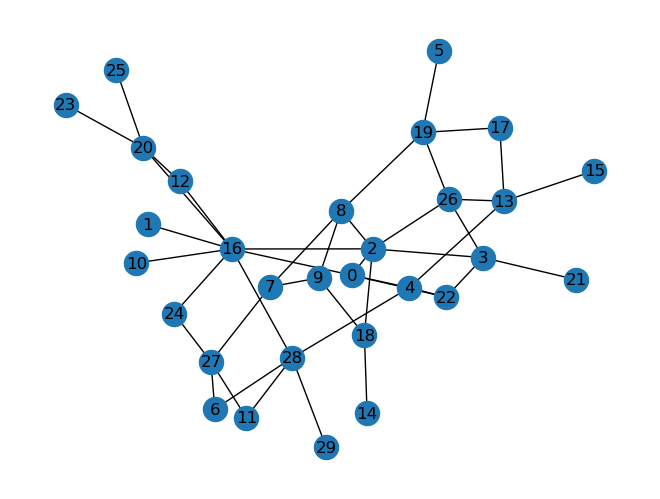

In [264]:
nx.draw_spring(G, with_labels=True)

## Vacancy-chain approach

In [277]:
def non_greedy(robot_location, unexplored, G=None): 
    total_cost = 0
    prob_dist = []
    if G == None: # simple grid case 
        for i in range(len(unexplored)): 
            total_cost += 1/euclidean(robot_location, unexplored[i])
        for j in range(len(unexplored)): 
            num = 1/euclidean(robot_location, unexplored[j])
            prob_dist.append(num/total_cost)
    else: # graph network case 
         for i in range(len(unexplored)): 
            total_cost += 1/cost_graph_simple(G, robot_location, unexplored[i])
         for j in range(len(unexplored)): 
             num = 1/cost_graph_simple(G, robot_location, unexplored[j])
             prob_dist.append(num/total_cost)     
    
    winner = prob_dist.index(max(prob_dist))
    chosen_task = unexplored[winner]

    return chosen_task, 1/num


In [278]:
task_locations, robot_locations, map = generate_scene(5, 2, 3)

In [279]:
task_locations

[(1, 3), (1, 1), (0, 3)]

In [280]:
robot_locations

[(2, 3), (4, 3)]

In [281]:
robot_location = robot_locations[0]
unexplored = task_locations

non_greedy(robot_location, unexplored)

(1, 3)

<Axes: >

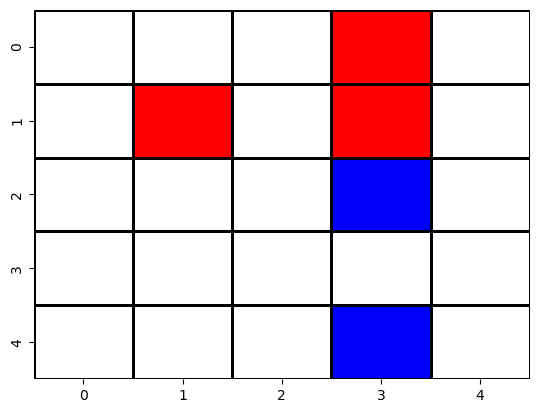

In [282]:
vizmap(map)

In [390]:
class robot: 
    def __init__(self, robot_location):
        self.current_location = robot_location 
        self.assigned_tasks = []

    def non_greedy(self, unexplored, G=None): 
        total_cost = 0
        prob_dist = []
        if G == None: # simple grid case 
            for i in range(len(unexplored)): 
                total_cost += 1/euclidean(self.current_location, unexplored[i])
            for j in range(len(unexplored)): 
                num = 1/euclidean(self.current_location, unexplored[j])
                prob_dist.append(num/total_cost)
        else: # graph network case 
            for i in range(len(unexplored)): 
                total_cost += 1/cost_graph_simple(G, self.current_location, unexplored[i])
            for j in range(len(unexplored)): 
                num = 1/cost_graph_simple(G, self.current_location, unexplored[j])
                prob_dist.append(num/total_cost)     
        
        winner = prob_dist.index(max(prob_dist))
        chosen_task = unexplored[winner]

        return winner, 1/num
    
    def get_broadcasts(self, another_robot, unexplored, G=None): 
        win=True
        chosen_task, cost = self.non_greedy(unexplored, G)
        other_chosen_task, other_cost = another_robot.non_greedy(unexplored, G)
        if chosen_task == other_chosen_task: 
            if cost > other_cost: 
                win=False 
        return win 

            
def simulate_one_time_step(robots, task_locations, G=None): 
    unexplored = task_locations
    allocs = {}
    u = 0
    for robot in robots: 
        allocs['Robot {}'.format(u)] = [robot.current_location]
        u += 1
    for i in range(len(robots)): 
        if len(unexplored) == 0: 
            break
        for j in range(len(robots)): 
            if j==i: 
                continue
            status = robots[i].get_broadcasts(robots[j], unexplored, G)
            if not status: 
                break
        if status: 
            winner, _ = robots[i].non_greedy(unexplored, G)
            robots[i].current_location =unexplored[winner]
            allocs['Robot {}'.format(i)].append(unexplored.pop(winner))

    return allocs



In [391]:
task_locations, robot_locations, map = generate_scene(10, 3, 4)

In [392]:

task_locations

[(6, 5), (6, 7), (8, 3), (4, 2)]

In [393]:
robot_locations

[(0, 9), (4, 3), (1, 2)]

<Axes: >

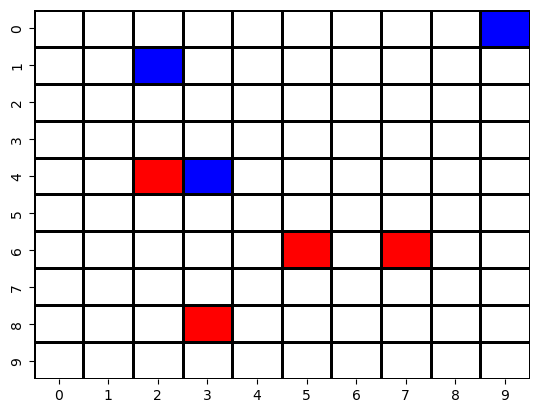

In [394]:
vizmap(map)

In [395]:
robots = [] 
for i in range(len(robot_locations)): 
    robots.append(robot(robot_locations[i]))

In [396]:
robots

In [397]:
allocs = simulate_one_time_step(robots, task_locations)

In [398]:
allocs

{'Robot 0': [(0, 9), (6, 7)], 'Robot 1': [(4, 3), (4, 2)], 'Robot 2': [(1, 2)]}

In [328]:
test = [1, 2, 3]
test2 = test
test2.pop() 
test

[1, 2]